**Title**

**Introduction**

**Methods and Results**

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(dplyr))

In [2]:
url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_heart_data<-read_csv(url, col_names=FALSE)%>%
rename(age=X1,
       sex=X2,
       cp=X3,
       trestbps=X4,
       chol=X5,
       fbs=X6,
       restecg=X7,
       thalach=X8,
       exang=X9,
       oldpeak=X10,
       slope=X11,
       ca=X12,
       thal=X13,
       num=X14)     

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
cleveland_heart_data$sex<-ifelse(cleveland_heart_data$sex == 1, 'male', 'female')

cleveland_heart_data$fbs<-ifelse(cleveland_heart_data$fbs == 1, '>120', '<120')

cleveland_heart_data$exang<-ifelse(cleveland_heart_data$exang == 1, 'yes', 'no')

cleveland_heart_data$num<-ifelse(cleveland_heart_data$num == 0, 'no_disease', 'has_disease')

cleveland_heart_data$cp<-ifelse(cleveland_heart_data$cp == 1, 'typical_angina',
                                ifelse(cleveland_heart_data$cp == 2, 'atypical_angina',
                                       ifelse(cleveland_heart_data$cp == 3, 'non_anginal_pain', 'asymptomatic')))

cleveland_heart_data$slope<-ifelse(cleveland_heart_data$slope == 1, 'upsloping',
                                   ifelse(cleveland_heart_data$slope == 2, 'flat', 'downsloping'))

In [4]:
cleveland_heart_data<-cleveland_heart_data%>%
mutate(num=as_factor(num))

In [5]:
cleveland_heart_data<-cleveland_heart_data%>%
select(chol, trestbps, thalach, num)
head(cleveland_heart_data)

chol,trestbps,thalach,num
<dbl>,<dbl>,<dbl>,<fct>
233,145,150,no_disease
286,160,108,has_disease
229,120,129,has_disease
250,130,187,no_disease
204,130,172,no_disease
236,120,178,no_disease


In [6]:
set.seed(1772)
heart_split<-initial_split(cleveland_heart_data, prop=0.75, strata=num)
heart_train<-training(heart_split)
heart_test<-testing(heart_split)

In [7]:
heart_recipe<-recipe(num ~ chol+trestbps+thalach, data=heart_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

heart_knn<-nearest_neighbor(weight_func="rectangular", neighbors=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

In [8]:
heart_vfold<-vfold_cv(heart_train, v=5, strata=num)

In [9]:
gridvals<-tibble(neighbors=seq(from=1, to=100, by=5))

In [10]:
knn_heart_results<-workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(heart_knn)%>%
    tune_grid(resamples=heart_vfold, grid=gridvals)%>%
    collect_metrics()%>%
    filter(.metric=="accuracy")%>%
    arrange(by=desc(mean))
head(knn_heart_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,accuracy,binary,0.7340184,5,0.04937380,Preprocessor1_Model09
36,accuracy,binary,0.7208740,5,0.05078252,Preprocessor1_Model08
46,accuracy,binary,0.7163329,5,0.05218648,Preprocessor1_Model10
26,accuracy,binary,0.7076372,5,0.04963495,Preprocessor1_Model06
6,accuracy,binary,0.6991436,5,0.03828527,Preprocessor1_Model02
31,accuracy,binary,0.6988450,5,0.04669202,Preprocessor1_Model07


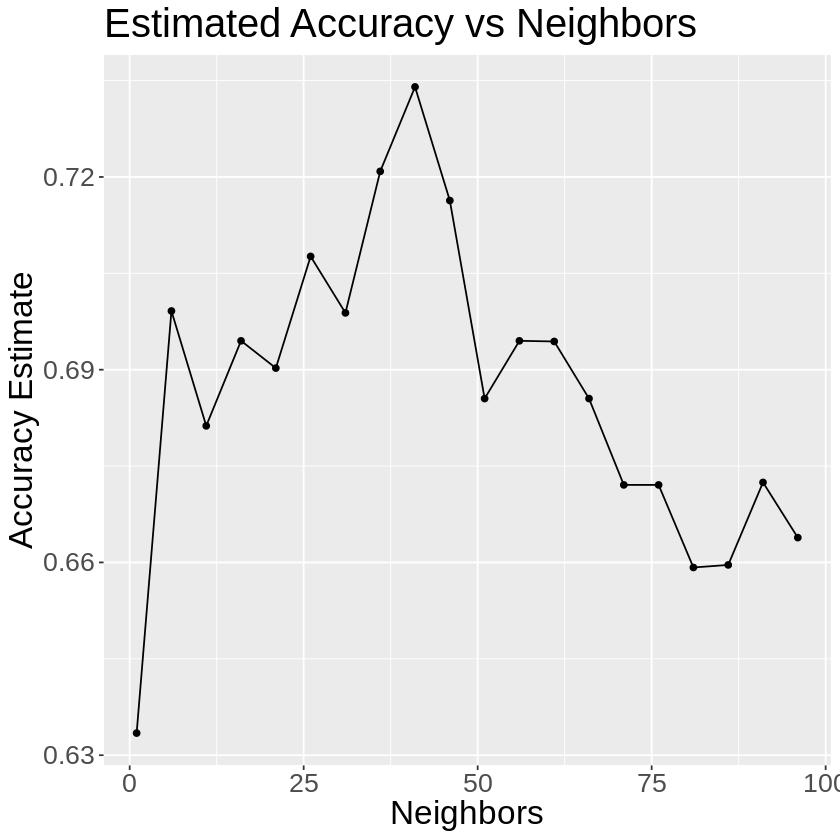

In [11]:
knn_heart_graph<-knn_heart_results%>%
ggplot(aes(x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x="Neighbors", y="Accuracy Estimate")+
theme(text=element_text(size=20))+
ggtitle("Estimated Accuracy vs Neighbors")
knn_heart_graph

In [12]:
knn_heart_best<-nearest_neighbor(weight_func="rectangular", neighbors=41)%>%
    set_engine("kknn")%>%
    set_mode("classification")

heart_fit<-workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(knn_heart_best)%>%
    fit(data=heart_train)

In [13]:
heart_predictions<-heart_fit%>%
    predict(heart_test)%>%
    bind_cols(heart_test)%>%
    metrics(truth=num, estimate=.pred_class)%>%
    filter(.metric=="accuracy")
heart_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6710526
